

                           Modelo predictivo xgboost                            
                                Aquino Rodríguez                                


📊 RMSE: 4,767,127
📈 R²: 0.5898


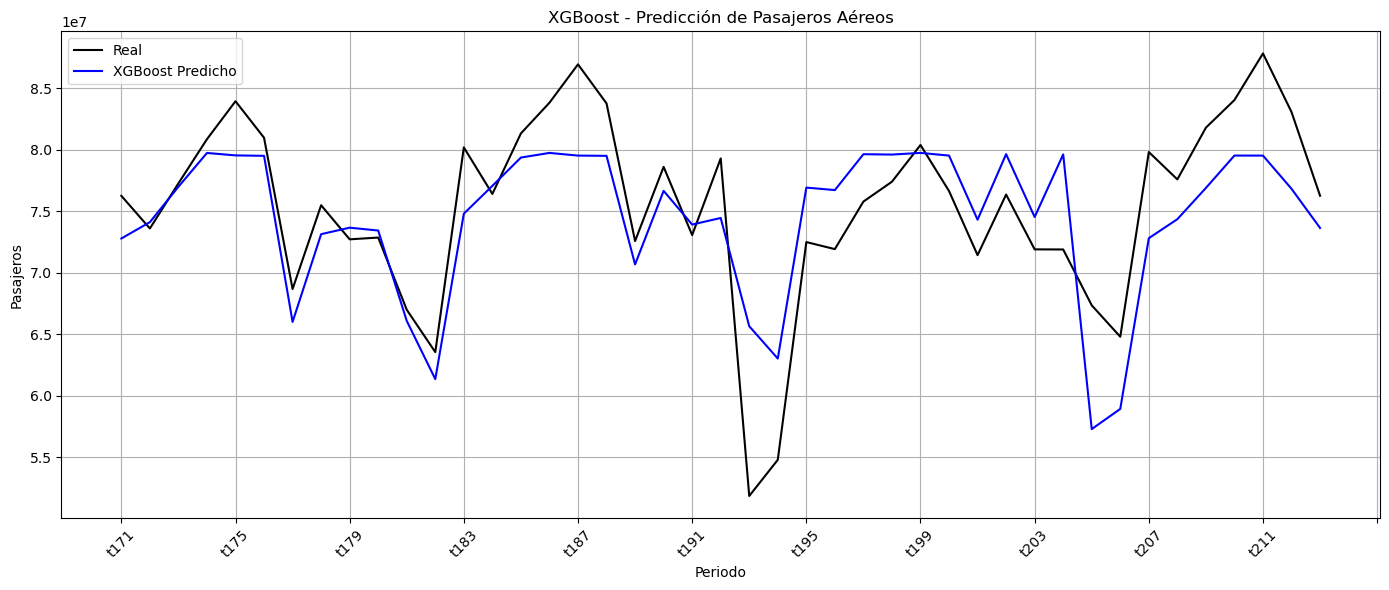

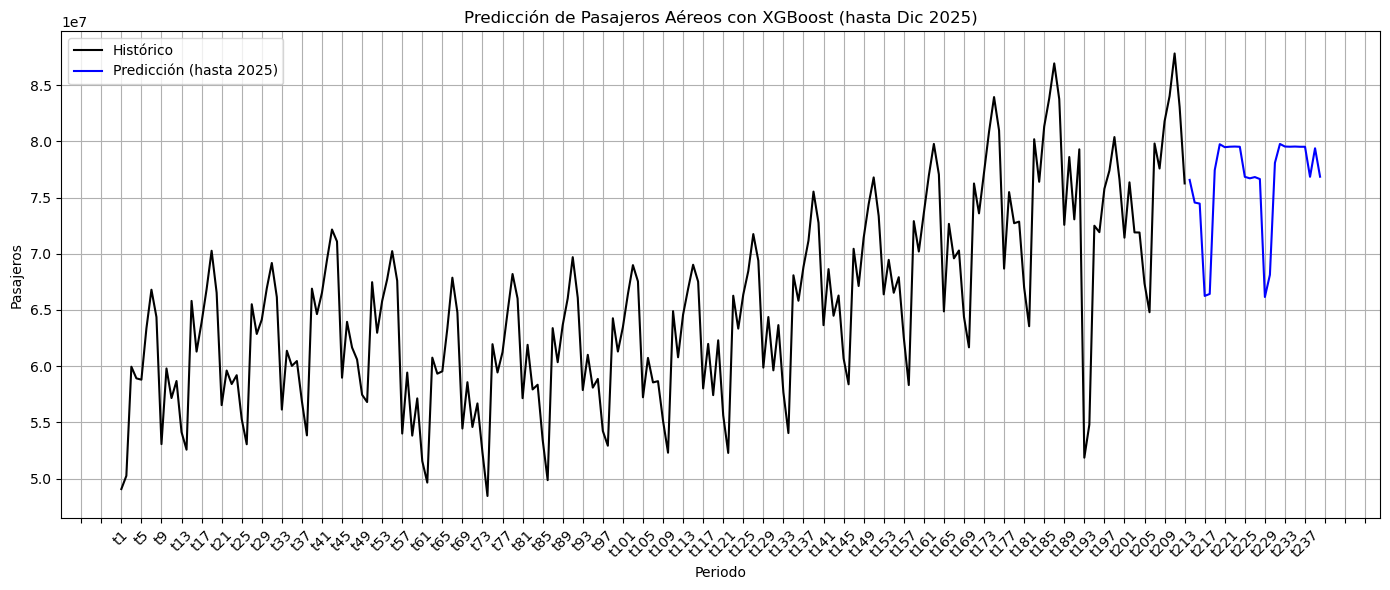


📅 Predicciones de pasajeros (Oct 2023 a Dic 2025):

t214: 2023-10 → 76,565,328 pasajeros
t215: 2023-11 → 74,551,784 pasajeros
t216: 2023-12 → 74,457,320 pasajeros
t217: 2024-01 → 66,246,460 pasajeros
t218: 2024-02 → 66,424,316 pasajeros
t219: 2024-03 → 77,438,096 pasajeros
t220: 2024-04 → 79,737,600 pasajeros
t221: 2024-05 → 79,476,912 pasajeros
t222: 2024-06 → 79,517,264 pasajeros
t223: 2024-07 → 79,532,000 pasajeros
t224: 2024-08 → 79,512,312 pasajeros
t225: 2024-09 → 76,839,056 pasajeros
t226: 2024-10 → 76,705,992 pasajeros
t227: 2024-11 → 76,817,464 pasajeros
t228: 2024-12 → 76,641,992 pasajeros
t229: 2025-01 → 66,154,156 pasajeros
t230: 2025-02 → 68,125,080 pasajeros
t231: 2025-03 → 78,082,112 pasajeros
t232: 2025-04 → 79,763,560 pasajeros
t233: 2025-05 → 79,531,680 pasajeros
t234: 2025-06 → 79,517,264 pasajeros
t235: 2025-07 → 79,532,000 pasajeros
t236: 2025-08 → 79,512,312 pasajeros
t237: 2025-09 → 79,512,312 pasajeros
t238: 2025-10 → 76,839,280 pasajeros
t239: 2025-11 → 79,378

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

print()
print()
ancho = 80

# Códigos ANSI para color
amarillo = "\033[94m"
reset = "\033[0m"

print(amarillo + 'Modelo predictivo xgboost'.center(ancho) + reset)
print(amarillo + 'Aquino Rodríguez'.center(ancho) + reset)
print()
print()

# 1. Cargar y preparar datos
df = pd.read_csv("air_traffic_final.csv")
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.sort_values('Date')
df = df[['Date', 'Pax']]
df.set_index('Date', inplace=True)

# 2. Eliminar 2020 y 2021
df = df[~df.index.year.isin([2020, 2021])]

# 3. Lags
for lag in [1, 2, 3, 12]:
    df[f'lag_{lag}'] = df['Pax'].shift(lag)

# 4. Variables de fecha
df['mes'] = df.index.month
df['año'] = df.index.year

# 5. Eliminar nulos
df = df.dropna()

# 6. Crear columna 'Periodo' tipo t1, t2, ..., tn
df['Periodo'] = ['t' + str(i + 1) for i in range(len(df))]

# 7. Train/Test
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

features = ['lag_1', 'lag_2', 'lag_3', 'lag_12', 'mes', 'año']
X_train, y_train = train[features], train['Pax']
X_test, y_test = test[features], test['Pax']
test_periodos = test['Periodo']

# 8. Entrenar modelo XGBoost
xgb = XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# 9. Predicción
pred = xgb.predict(X_test)

# 10. Evaluación
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"📊 RMSE: {rmse:,.0f}")
print(f"📈 R²: {r2:.4f}")

# 11. Gráfico de predicción vs real usando 'Periodo'
plt.figure(figsize=(14, 6))
plt.plot(test_periodos, y_test.values, label='Real', color='black')
plt.plot(test_periodos, pred, label='XGBoost Predicho', color='blue')
plt.title('XGBoost - Predicción de Pasajeros Aéreos')
plt.xlabel('Periodo')
plt.ylabel('Pasajeros')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MultipleLocator(4))  # Mostrar cada 4 periodos
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print()
print()
# 12. Forecast extendido (hasta 2025)
last_date = df.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), end='2025-12-01', freq='MS')
future_df = pd.DataFrame(index=future_dates)

# Inicializar columnas
future_df['mes'] = future_df.index.month
future_df['año'] = future_df.index.year
for lag in [1, 2, 3, 12]:
    future_df[f'lag_{lag}'] = np.nan

# Concatenar original + futuro
full_df = pd.concat([df.copy(), future_df.copy()])

# Generar predicciones paso a paso
for date in future_df.index:
    for lag in [1, 2, 3, 12]:
        prev_date = date - pd.DateOffset(months=lag)
        full_df.loc[date, f'lag_{lag}'] = full_df.loc[prev_date, 'Pax']
    row = full_df.loc[[date], features]
    full_df.loc[date, 'Pax'] = xgb.predict(row)[0]

# Crear Periodos para toda la serie
full_df['Periodo'] = ['t' + str(i + 1) for i in range(len(full_df))]
forecast = full_df.loc[future_dates, 'Pax']
forecast_periodos = full_df.loc[future_dates, 'Periodo']

# 13. Gráfico extendido usando Periodos
plt.figure(figsize=(14, 6))
plt.plot(df['Periodo'], df['Pax'], label='Histórico', color='black')
plt.plot(forecast_periodos, forecast.values, label='Predicción (hasta 2025)', color='blue')
plt.title('Predicción de Pasajeros Aéreos con XGBoost (hasta Dic 2025)')
plt.xlabel('Periodo')
plt.ylabel('Pasajeros')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MultipleLocator(4))  # Mostrar cada 4 periodos
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


rango_pred = full_df.loc['2023-10-01':'2025-12-01', ['Pax', 'Periodo']]
print("\n📅 Predicciones de pasajeros (Oct 2023 a Dic 2025):\n")
for fecha, fila in rango_pred.iterrows():
    pax = int(round(fila['Pax']))
    print(f"{fila['Periodo']}: {fecha.strftime('%Y-%m')} → {pax:,} pasajeros")